#  Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


# Load and Preprocess Data

In [10]:
# Load the dataset (adjust path as needed)
daily_df = pd.read_csv("Data/BTC-Daily.csv")

# Preview data
daily_df.head()


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [ ]:
# Convert 'date' column to datetime
daily_df['date'] = pd.to_datetime(daily_df['date'])

# Sort by date just in case
daily_df = daily_df.sort_values('date').reset_index(drop=True)

# Drop rows with missing values (or fill if needed)
daily_df = daily_df.dropna()

# Filter data for training and testing
train_df = daily_df[daily_df['date'] < '2020-01-01'].copy()
test_df = daily_df[daily_df['date'] >= '2020-01-01'].copy()

# Extract the close prices
train_prices = train_df['close'].values
test_prices = test_df['close'].values


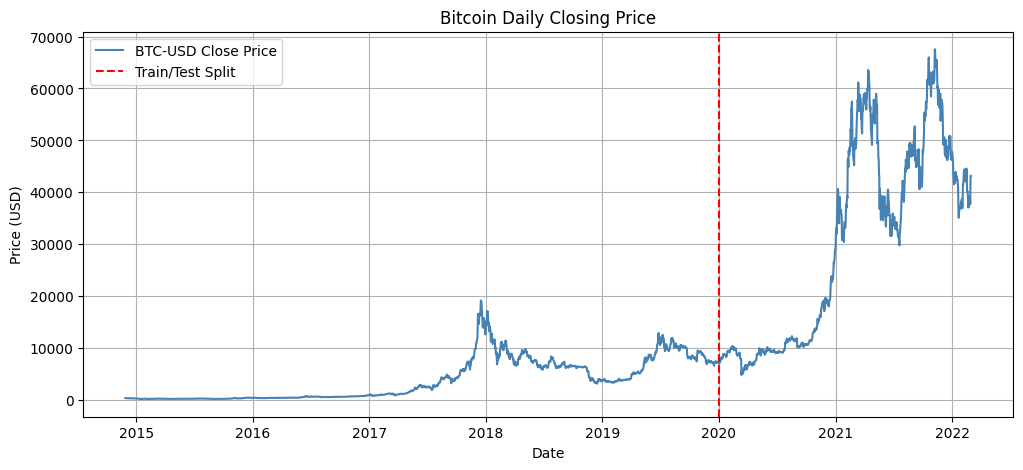

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(daily_df['date'], daily_df['close'], label="BTC-USD close Price", color='steelblue')
plt.axvline(pd.to_datetime("2020-01-01"), color="red", linestyle="--", label="Train/Test Split")
plt.title("Bitcoin Daily Closing Price")
plt.xlabel("date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


# Implement WMA Filters

### (a). Simple Moving Average (SMA)


In [22]:
def sma(series, window):
    if len(series) < window:
        return np.array([])  # return empty if not enough data
    return np.convolve(series, np.ones(window) / window, mode='valid')


### (b). Linear Weighted Moving Average (LMA)

In [21]:
def lma(series, window):
    if len(series) < window:
        return np.array([])
    weights = np.arange(1, window + 1)
    weights = weights / weights.sum()
    return np.convolve(series, weights, mode='valid')


### (c). Exponential Moving Average (EMA)

In [23]:
def ema(series, window, alpha=0.3):
    """
    Exponential Moving Average
    Applies exponentially decreasing weights.
    Alpha controls the rate of decay.
    """
    if len(series) < window:
        return np.array([])
    weights = [(1 - alpha) ** i for i in range(window)]
    weights = np.array(weights[::-1])  # reverse so most recent has highest weight
    weights = weights / weights.sum()
    return np.convolve(series, weights, mode='valid')


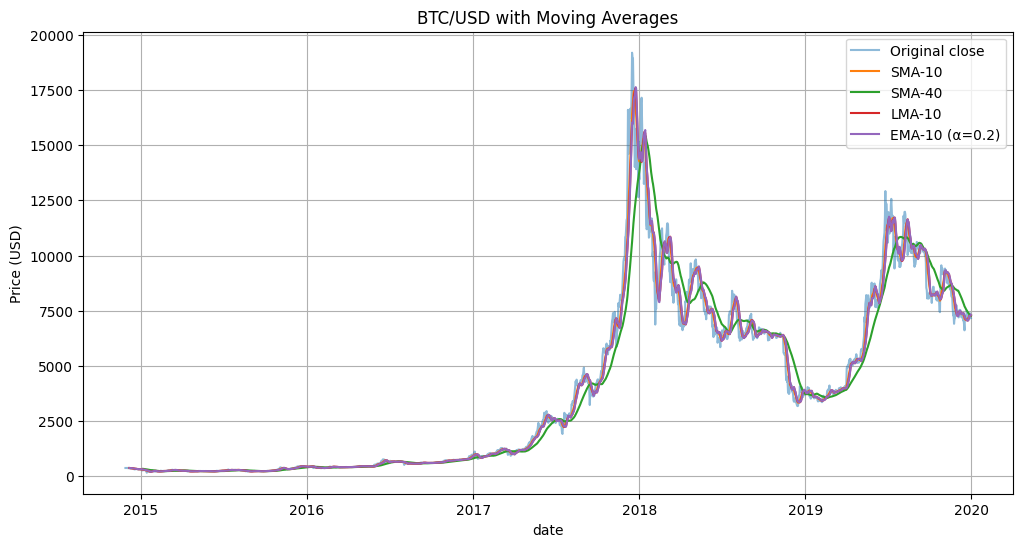

In [25]:
window_short = 10
window_long = 40
alpha_val = 0.2

plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['close'], label="Original close", alpha=0.5)

plt.plot(train_df['date'][window_short - 1:], sma(train_prices, window_short), label=f"SMA-{window_short}")
plt.plot(train_df['date'][window_long - 1:], sma(train_prices, window_long), label=f"SMA-{window_long}")

plt.plot(train_df['date'][window_short - 1:], lma(train_prices, window_short), label=f"LMA-{window_short}")
plt.plot(train_df['date'][window_short - 1:], ema(train_prices, window_short, alpha=alpha_val), label=f"EMA-{window_short} (α={alpha_val})")

plt.title("BTC/USD with Moving Averages")
plt.xlabel("date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


# Implement Crossover Logic

In [ ]:
def detect_crossovers(short_ma, long_ma):
    # Align the lengths by trimming the longer MA
    min_len = min(len(short_ma), len(long_ma))
    short_ma = short_ma[-min_len:]
    long_ma = long_ma[-min_len:]
    
    diff = short_ma - long_ma
    signals = []

    for i in range(1, len(diff)):
        if diff[i-1] < 0 and diff[i] > 0:
            signals.append(1)   # Buy
        elif diff[i-1] > 0 and diff[i] < 0:
            signals.append(-1)  # Sell
        else:
            signals.append(0)   # Hold

    # Pad the signal list to match original series length
    signals = [0] + signals  # First point has no previous
    return np.array(signals)


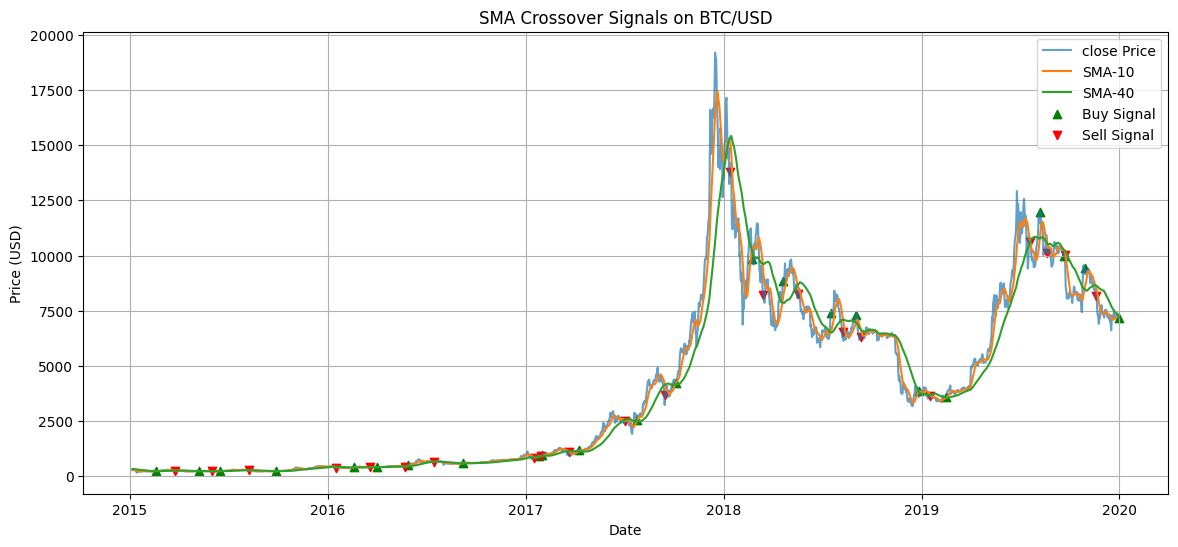

In [28]:
# Create SMA signals
sma_short = sma(train_prices, window=10)
sma_long = sma(train_prices, window=40)

# Detect crossovers
sma_signals = detect_crossovers(sma_short, sma_long)

# Align corresponding dates
signal_dates = train_df['date'][(max(10, 40) - 1):]  # Trim date to match signal length
signal_prices = train_prices[(max(10, 40) - 1):]

# Visualize Buy/Sell Signals
plt.figure(figsize=(14, 6))
plt.plot(signal_dates, signal_prices, label="close Price", alpha=0.7)
plt.plot(signal_dates, sma_short[-len(signal_dates):], label="SMA-10")
plt.plot(signal_dates, sma_long[-len(signal_dates):], label="SMA-40")

# Plot Buy/Sell points
buy_points = signal_prices[sma_signals == 1]
sell_points = signal_prices[sma_signals == -1]
buy_dates = signal_dates[sma_signals == 1]
sell_dates = signal_dates[sma_signals == -1]

plt.scatter(buy_dates, buy_points, marker='^', color='green', label='Buy Signal')
plt.scatter(sell_dates, sell_points, marker='v', color='red', label='Sell Signal')

plt.title("SMA Crossover Signals on BTC/USD")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


# Backtesting Function (Simulates Trading)

- Start with $1000 USD and 0 BTC
- On buy signal, convert all cash into BTC (at price − 3% fee)
- On sell signal, convert all BTC into cash (at price − 3% fee)
- At the end, convert any remaining BTC into cash at the final price
- Return final USD value as fitness score

In [29]:
def backtest(prices, signals, fee=0.03, initial_cash=1000):
    cash = initial_cash
    btc = 0
    equity_curve = []

    for i in range(len(prices)):
        price = prices[i]
        signal = signals[i]

        if signal == 1 and cash > 0:
            # Buy BTC with all cash
            btc = (cash * (1 - fee)) / price
            cash = 0
        elif signal == -1 and btc > 0:
            # Sell BTC for cash
            cash = (btc * price) * (1 - fee)
            btc = 0

        # Track portfolio value (cash + BTC value)
        total_equity = cash + btc * price
        equity_curve.append(total_equity)

    # Final sell if holding BTC
    if btc > 0:
        cash = (btc * prices[-1]) * (1 - fee)
        btc = 0
    equity_curve[-1] = cash  # Final portfolio value

    return cash, np.array(equity_curve)


Final portfolio value: $10576.12


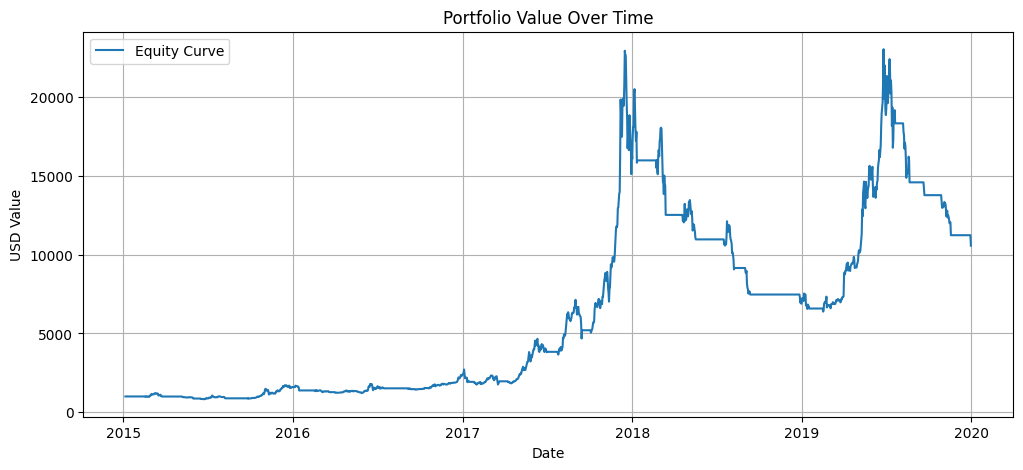

In [30]:
# Backtest on SMA strategy
final_cash, equity = backtest(signal_prices, sma_signals)

print(f"Final portfolio value: ${final_cash:.2f}")

# Plot equity curve
plt.figure(figsize=(12, 5))
plt.plot(signal_dates, equity, label="Equity Curve")
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("USD Value")
plt.grid()
plt.legend()
plt.show()


In [32]:
def evaluate_bot(params, prices, ma_type='sma', alpha=0.3, fee=0.03, verbose=False):
    """
    Generalized trading bot evaluator.

    Parameters:
    - params: [N_short, N_long]
    - prices: close price series (numpy array)
    - ma_type: 'sma', 'lma', or 'ema'
    - alpha: EMA decay factor (only used for 'ema')
    - fee: transaction fee
    - verbose: print result and optionally plot

    Returns:
    - final_cash: float
    """
    N_short = int(params[0])
    N_long = int(params[1])

    # Ensure valid window sizes
    if N_short >= N_long or N_short < 2 or N_long > len(prices) // 2:
        return 0  # Discard bad configs

    # Generate MAs
    if ma_type == 'sma':
        ma_short = sma(prices, N_short)
        ma_long = sma(prices, N_long)
    elif ma_type == 'lma':
        ma_short = lma(prices, N_short)
        ma_long = lma(prices, N_long)
    elif ma_type == 'ema':
        ma_short = ema(prices, N_short, alpha)
        ma_long = ema(prices, N_long, alpha)
    else:
        raise ValueError("Invalid MA type")

    # Detect crossovers
    signals = detect_crossovers(ma_short, ma_long)

    # Align prices to signals (they're shorter than original prices)
    price_offset = max(N_short, N_long) - 1
    aligned_prices = prices[price_offset:]

    # Backtest
    final_cash, equity = backtest(aligned_prices, signals, fee=fee)

    if verbose:
        print(f"Final cash: ${final_cash:.2f}")
        plt.figure(figsize=(12, 5))
        plt.plot(aligned_prices, label="Close Price")
        plt.plot(equity, label="Equity Curve")
        plt.title(f"Backtest Result (Final: ${final_cash:.2f})")
        plt.legend()
        plt.grid()
        plt.show()

    return final_cash


Final cash: $10576.12


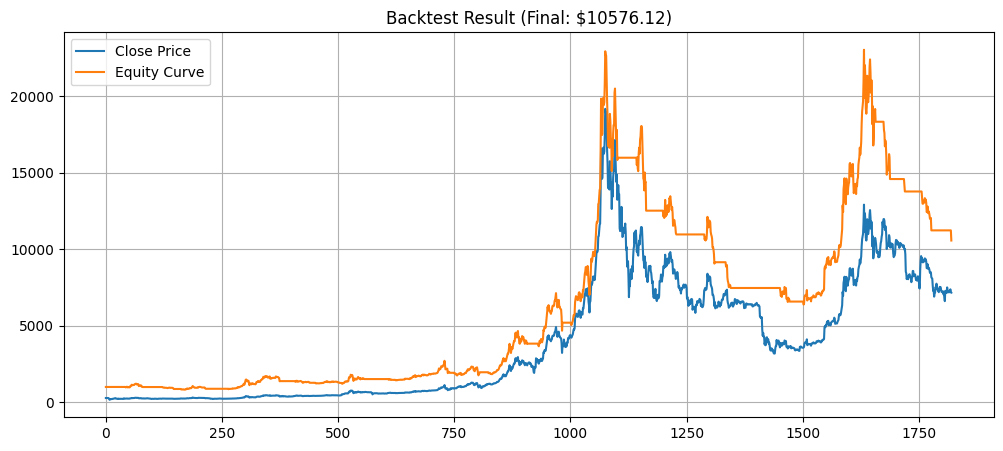

np.float64(10576.12020245786)

In [33]:
# Simple test: 10-day and 40-day SMA
evaluate_bot([10, 40], train_prices, ma_type='sma', verbose=True)


# Grey Wolf Optimizer

In [34]:
def gwo_optimize(fitness_func, dim, bounds, iterations=30, pack_size=10, verbose=True):
    """
    Grey Wolf Optimizer for continuous parameters.

    Parameters:
    - fitness_func: function to evaluate fitness (returns a scalar)
    - dim: number of dimensions (parameters)
    - bounds: list of (min, max) tuples for each parameter
    - iterations: number of optimization steps
    - pack_size: number of wolves in the population

    Returns:
    - best_position: parameters with highest fitness
    - best_score: final cash
    - history: score over time
    """
    # === Initialize positions ===
    wolves = np.random.uniform(
        [b[0] for b in bounds],
        [b[1] for b in bounds],
        size=(pack_size, dim)
    )

    # Evaluate initial fitness
    fitness = np.array([fitness_func(w) for w in wolves])
    
    # Initialize alpha, beta, delta
    alpha_idx = np.argmax(fitness)
    alpha_pos = wolves[alpha_idx].copy()
    alpha_score = fitness[alpha_idx]

    beta_score, delta_score = -np.inf, -np.inf
    beta_pos, delta_pos = None, None

    history = [alpha_score]

    # === Main loop ===
    for t in range(iterations):
        a = 2 - t * (2 / iterations)  # linearly decreasing

        for i in range(pack_size):
            for d in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2

                D_alpha = abs(C1 * alpha_pos[d] - wolves[i][d])
                X1 = alpha_pos[d] - A1 * D_alpha

                # Repeat for beta
                r1, r2 = np.random.rand(), np.random.rand()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * (beta_pos[d] if beta_pos is not None else alpha_pos[d]) - wolves[i][d])
                X2 = (beta_pos[d] if beta_pos is not None else alpha_pos[d]) - A2 * D_beta

                # Repeat for delta
                r1, r2 = np.random.rand(), np.random.rand()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * (delta_pos[d] if delta_pos is not None else alpha_pos[d]) - wolves[i][d])
                X3 = (delta_pos[d] if delta_pos is not None else alpha_pos[d]) - A3 * D_delta

                wolves[i][d] = np.clip((X1 + X2 + X3) / 3, bounds[d][0], bounds[d][1])

        # Evaluate new fitness
        fitness = np.array([fitness_func(w) for w in wolves])
        best_idx = np.argmax(fitness)
        best_score = fitness[best_idx]

        # Update alpha, beta, delta
        if best_score > alpha_score:
            delta_score, delta_pos = beta_score, beta_pos
            beta_score, beta_pos = alpha_score, alpha_pos
            alpha_score, alpha_pos = best_score, wolves[best_idx].copy()
        elif best_score > beta_score:
            delta_score, delta_pos = beta_score, beta_pos
            beta_score, beta_pos = best_score, wolves[best_idx].copy()
        elif best_score > delta_score:
            delta_score, delta_pos = best_score, wolves[best_idx].copy()

        history.append(alpha_score)
        if verbose:
            print(f"Iteration {t+1}: Best Fitness = {alpha_score:.2f}")

    return alpha_pos, alpha_score, history


In [35]:
# Define fitness wrapper for SMA
def sma_fitness(params):
    return evaluate_bot(params, train_prices, ma_type='sma')

# Search space: N_short (5 to 30), N_long (10 to 100)
bounds = [(5, 30), (10, 100)]

best_params, best_score, score_history = gwo_optimize(
    fitness_func=sma_fitness,
    dim=2,
    bounds=bounds,
    iterations=30,
    pack_size=10
)

print("\n🎯 Best Parameters:", best_params)
print("💰 Best Final Cash:", round(best_score, 2))


Iteration 1: Best Fitness = 27977.28
Iteration 2: Best Fitness = 27977.28
Iteration 3: Best Fitness = 27977.28
Iteration 4: Best Fitness = 27977.28
Iteration 5: Best Fitness = 27977.28
Iteration 6: Best Fitness = 27977.28
Iteration 7: Best Fitness = 27977.28
Iteration 8: Best Fitness = 27977.28
Iteration 9: Best Fitness = 27977.28
Iteration 10: Best Fitness = 27977.28
Iteration 11: Best Fitness = 27977.28
Iteration 12: Best Fitness = 27977.28
Iteration 13: Best Fitness = 27977.28
Iteration 14: Best Fitness = 27977.28
Iteration 15: Best Fitness = 27977.28
Iteration 16: Best Fitness = 27977.28
Iteration 17: Best Fitness = 27977.28
Iteration 18: Best Fitness = 27977.28
Iteration 19: Best Fitness = 27977.28
Iteration 20: Best Fitness = 27977.28
Iteration 21: Best Fitness = 27977.28
Iteration 22: Best Fitness = 27977.28
Iteration 23: Best Fitness = 27977.28
Iteration 24: Best Fitness = 27977.28
Iteration 25: Best Fitness = 27977.28
Iteration 26: Best Fitness = 27977.28
Iteration 27: Best Fi

### Plot the GWO Convergence Curve

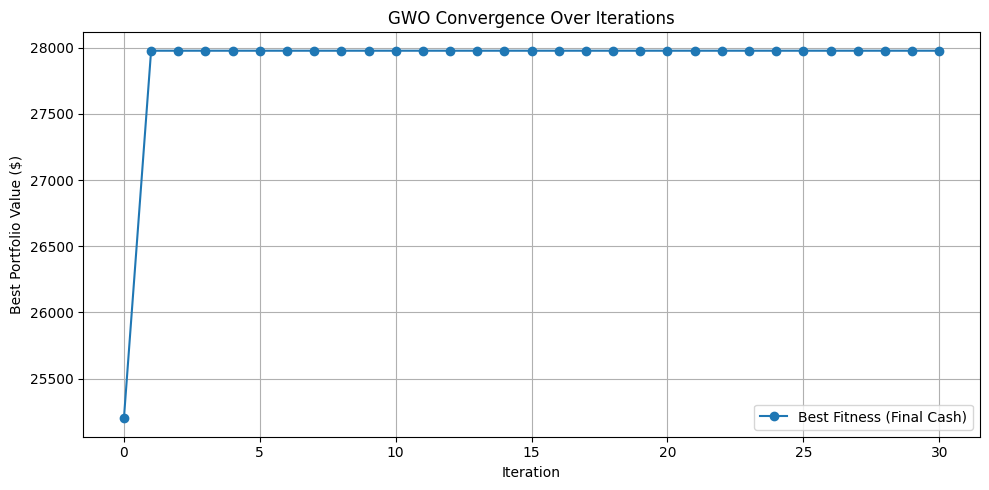

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(score_history, marker='o', label='Best Fitness (Final Cash)')
plt.title("GWO Convergence Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
